# Week 3 - Ungraded Lab: Data Labeling


Welcome to the ungraded lab for week 3 of Machine Learning Engineering for Production. In this lab, you will see how the data labeling process affects the performance of a classification model. Labeling data is usually a very labor intensive and costly task but it is of great importance.

As you saw in the lectures there are many ways to label data, this is dependant on the strategy used. Recall the example with the iguanas, all of the following are valid labeling alternatives but they clearly follow different criteria. 

<img src='img/iguanas.png'>

**You can think of every labeling strategy as a result of different labelers following different labeling rules**. If your data is labeled by people using different criteria this will have a negative impact on your learning algorithm. It is desired to have consistent labeling across your dataset.

This lab will touch on the effect of labeling strategies from a slighlty different angle. You will explore how different strategies affect the performance of a machine learning model by simulating the process of having different labelers label the data. This, by defining a set of rules and performing automatic labeling based on those rules.

**The main objective of this ungraded lab is to compare performance across labeling options to understand the role that good labeling plays on the performance of Machine Learning models**, these options are:
1. Randomly generated labels (performance lower bound)
2. Automatic generated labels based on three different label strategies
3. True labels (performance upper bound)

Although the example with the iguanas is a computer vision task, the same concepts regarding labeling can be applied to other types of data. In this lab you will be working with text data, concretely you will be using a dataset containing comments from the 2015 top 5 most popular Youtube videos. Each comment has been labeled as `spam` or `not_spam` depending on its contents.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the dataset

The dataset consists of 5 CSV files, one for each video. Pandas `DataFrame` are very powerful to handle data in CSV format. The following helper function will load the data using pandas:

In [9]:
# import the data from the excel file
xlsx_file_path = 'data/youtubeSpamCollection.xlsx'
# Specify the sheet name or index containing the CSV data within the Excel file
sheet_name = 'Worksheet'
# Read the Excel file
xls = pd.ExcelFile(xlsx_file_path)
# Parse the specific sheet containing the CSV data into a DataFrame
df = pd.read_excel(xls, sheet_name)

In [10]:
# Take a look at the first 5 rows
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^...,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .ï»¿,1


In [11]:
# now we rename the columns of this dataframe
df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

In [12]:
# Set a seed for the order of rows
df = df.sample(frac=1, random_state=824)
df.reset_index()

,index,COMMENT_ID,AUTHOR,DATE,text,label
0,1205,z12afj2p2pniy1idm23wclt4ox2wujzj004,Ernest Foli,2015-05-25T21:08:10.798000,fave songï»¿,0
1,1210,z13udxpqgtnnxt10o232vhgbspnveld0c,bossdon redhouse,2015-05-25T15:53:41.740000,I really am madly in love with this woman!!ï»¿,0
2,410,z12us3jzyurkxzntu22bvnpwskjdx1jkk,Vincenzo Canino 98,2014-09-28T12:38:26,Fantastic!!!ï»¿,0
3,105,z12kuncrps35wp1l0220s3t4ym32dtpin04,Aleksaivan Neidert,2014-11-05T15:35:49,PSY - GANGNAM STYLE (ê°•ë‚¨ìŠ¤íƒ€ì¼) M/V: htt...,0
4,1263,z13ldttruqm1x1wsz23qcdlq4saefnkew,Wiki Smolinska,2015-05-22T09:47:17.977000,Cool song ï»¿,0
...,...,...,...,...,...,...
1489,419,z122gn04syvfep31i22zd1xh1p2bul5g504,Sanfermuebles Muebles,2014-10-03T19:58:57,https://www.facebook.com/profile.php?id=100007...,1
1490,556,z12wctyrfvndsj32n23yhrhrxlyiulpcn,Michael Whiteside,2015-05-28T03:08:19.077000,I love this song so muchï»¿,0
1491,827,z124jvbxusjnsn2oi04cidm5hqmoftu4ovg0k,XxNorwegianELITEGaming xX,2015-01-31T20:56:05.396000,pleas subscribe on me for ps4 games videoÂ <br...,1
1492,237,z12mubjyckfjvhmni23bc5nxbnrggtvjq04,Bishwaroop Bhattacharjee,2014-11-08T12:34:11,https://www.facebook.com/SchoolGeniusNITS/phot...,1


In [13]:
df_labeled = df

To have a feeling of how the data is organized, let's inspect the top 5 rows of the data:

In [14]:
# Take a look at the first 5 rows
df_labeled.head()

,COMMENT_ID,AUTHOR,DATE,text,label
1205,z12afj2p2pniy1idm23wclt4ox2wujzj004,Ernest Foli,2015-05-25T21:08:10.798000,fave songï»¿,0
1210,z13udxpqgtnnxt10o232vhgbspnveld0c,bossdon redhouse,2015-05-25T15:53:41.740000,I really am madly in love with this woman!!ï»¿,0
410,z12us3jzyurkxzntu22bvnpwskjdx1jkk,Vincenzo Canino 98,2014-09-28T12:38:26,Fantastic!!!ï»¿,0
105,z12kuncrps35wp1l0220s3t4ym32dtpin04,Aleksaivan Neidert,2014-11-05T15:35:49,PSY - GANGNAM STYLE (ê°•ë‚¨ìŠ¤íƒ€ì¼) M/V: htt...,0
1263,z13ldttruqm1x1wsz23qcdlq4saefnkew,Wiki Smolinska,2015-05-22T09:47:17.977000,Cool song ï»¿,0


## Further inspection and preprocessing


### Checking for data imbalance

It is fairly common to assume that the data you are working on is balanced. This means that the dataset contains a similar proportion of examples for all classes. Before moving forward let's actually test this assumption:

Value counts for each class:

0    791
1    703
Name: label, dtype: int64



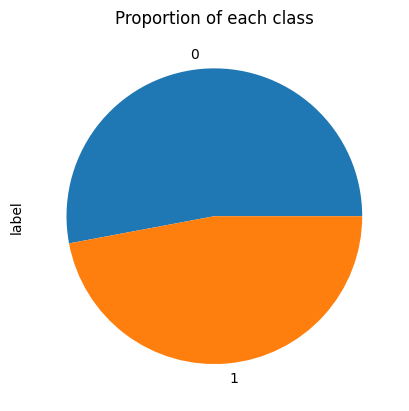

In [15]:
# Print actual value count
print(f"Value counts for each class:\n\n{df_labeled.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df_labeled.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

There is roughly the same number of data points for each class so class imbalance is not an issue for this particular dataset.


### Cleaning the dataset

If you scroll back to the cell where  you inspected the data, you will realize that the dataframe includes information that is not relevant for the task at hand. At the moment, you are only interested in the comments and the corresponding labels (the video that each comment belongs to will be used later). Let's drop the remaining columns.

In [17]:
# Drop unused columns
df_labeled = df_labeled.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

# Look at the cleaned dataset
df_labeled.head()

,text,label
1205,fave songï»¿,0
1210,I really am madly in love with this woman!!ï»¿,0
410,Fantastic!!!ï»¿,0
105,PSY - GANGNAM STYLE (ê°•ë‚¨ìŠ¤íƒ€ì¼) M/V: htt...,0
1263,Cool song ï»¿,0


Now the dataset only includes the information you are going to use moving forward.

### Splitting the dataset

Before jumping to the data labeling section let's split the data into training and test sets so you can use the latter to measure the performance of models that were trained using data labeled through different methods. As a safety measure when doing this split, remember to use stratification so the proportion of classes is maintained within each split.

In [18]:
from sklearn.model_selection import train_test_split

# Save the text into the X variable
X = df_labeled.drop("label", axis=1)

# Save the true labels into the y variable
y = df_labeled["label"]

# Use 1/5 of the data for testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print number of comments for each set
print(f"There are {X_train.shape[0]} comments for training.")
print(f"There are {X_test.shape[0]} comments for testing")

There are 1195 comments for training.
There are 299 comments for testing


Let's do a visual to check that the stratification actually worked:

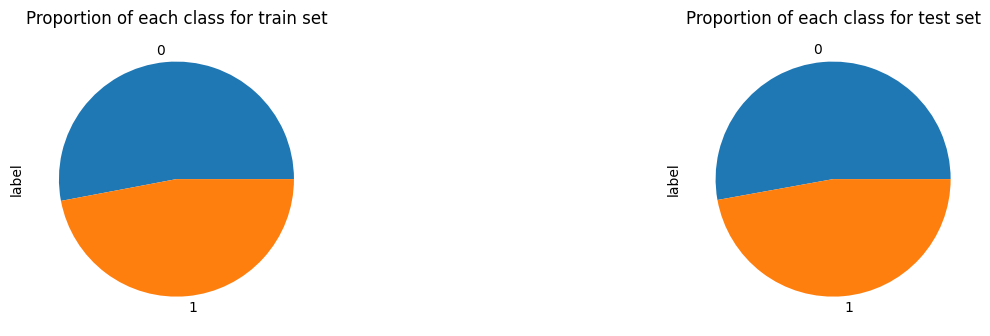

In [19]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

Both, the training and test sets a balanced proportion of examples per class. So, the code successfully implemented stratification.  

Let's get going!

## Data Labeling 

### Establishing performance lower and upper bounds for reference

To properly compare different labeling strategies you need to establish a baseline for model accuracy, in this case you will establish both a lower and an upper bound to compare against. 



### Calculate accuracy of a labeling strategy

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) is a handy tool included in the sklearn ecosystem to encode text based data.

For more information on how to work with text data using sklearn check out this [resource](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Allow unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 5))

Now that the text encoding is defined, you need to select a model to make predictions. For simplicity you will use a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier. This model is well suited for text classification and is fairly quick to train.

Let's define a function which will handle the model fitting and print out the accuracy on the test data:

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


def calculate_accuracy(X_tr, y_tr, X_te=X_test, y_te=y_test, 
                       clf=MultinomialNB(), vectorizer=vectorizer):
    
    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_tr.text.tolist())
    
    # Fit model
    clf.fit(X=X_train_vect, y=y_tr)
    
    # Vectorize test text
    X_test_vect = vectorizer.transform(X_te.text.tolist())
    
    # Make predictions for the test set
    preds = clf.predict(X_test_vect)
    
    # Return accuracy score
    return accuracy_score(preds, y_te)


Now let's create a dictionary  to store the accuracy of each labeling method:

In [22]:
# Empty dictionary
accs = dict()

### Random Labeling

Generating random labels is a natural way to establish a lower bound. You will expect that any successful alternative labeling model to outperform randomly generated labels. 

Now let's calculate the accuracy for the random labeling method

In [23]:
# Calculate random labels
rnd_labels = np.random.randint(0, 2, X_train.shape[0])

# Feed them alongside X_train to calculate_accuracy function
rnd_acc = calculate_accuracy(X_train, rnd_labels)

rnd_acc

0.4816053511705686

You will see a different accuracy everytime you run the previous cell. This is due to the fact that the labeling is done randomly. Remember, this is a binary classification problem and both classes are balanced, so you can expect to see accuracies that revolve around 50%.

To further gain intuition let's look at the average accuracy over 10 runs:

In [24]:
# Empty list to save accuracies
rnd_accs = []

for _ in range(10):
    # Add every accuracy to the list
    rnd_accs.append(calculate_accuracy(X_train, np.random.randint(0, 2, X_train.shape[0])))

# Save result in accs dictionary
accs['random-labels'] = sum(rnd_accs)/len(rnd_accs)

# Print result
print(f"The random labelling method achieved and accuracy of {accs['random-labels']*100:.2f}%")

The random labelling method achieved and accuracy of 47.16%


Random labelling is completely disregarding the information from the solution space you are working on, and is just guessing the correct label. You can't probably do worse than this (or maybe you can). For this reason, this method serves as reference for comparing other labeling methods


### Labeling with true values

Now let's look at the other end of the spectrum, this is using the correct labels for your data points. Let's retrain the Multinomial Naive Bayes classifier with the actual labels 

In [25]:
# Calculate accuracy when using the true labels
true_acc = calculate_accuracy(X_train, y_train)

# Save the result
accs['true-labels'] = true_acc

print(f"The true labelling method achieved and accuracy of {accs['true-labels']*100:.2f}%")

The true labelling method achieved and accuracy of 91.64%


Training with the true labels produced a noticeable boost in accuracy. This is expected as the classifier is now able to properly identify patterns in the training data which were lacking with randomly generated labels. 

Achieving higher accuracy is possible by either fine-tunning the model or even selecting a different one. For the time being you will keep the model as it is and use this accuracy as what we should strive for with the automatic labeling algorithms you will see next.

## Automatic labeling - Trying out different labeling strategies

Let's suppose that for some reason you don't have access to the true labels associated with each data point in this dataset. It is a natural idea to think that there are patterns in the data that will provide clues of which are the correct labels. This is of course very dependant on the kind of data you are working with and to even hypothesize which patterns exist requires great domain knowledge.

The dataset used in this lab was used for this reason. It is reasonable for many people to come up with rules that might help identify a spam comment from a non-spam one for a Youtube video. In the following section you will be performing automatic labeling using such rules. **You can think of each iteration of this process as a labeler with different criteria for labeling** and your job is to hire the most promising one.

Notice the word **rules**. In order to perform automatic labeling you will define some rules such as "if the comment contains the word 'free' classify it as spam".

First things first. Let's define how we are going to encode the labeling:
- `SPAM` is represented by 1


- `NOT_SPAM` by 0 


- `NO_LABEL` as -1


You might be wondering about the `NO_LABEL` keyword. Depending on the rules you come up with, these might not be applicable to some data points. For such cases it is better to refuse from giving a label rather than guessing, which you already saw yields poor results.

### First iteration - Define some rules

For this first iteration you will create three  rules based on the intuition of common patterns that appear on spam comments. The rules are simple, classify as SPAM if any of the following patterns is present within the comment or NO_LABEL otherwise:
- `free` - spam comments usually lure users by promoting free stuff
- `subs` - spam comments tend to ask users to subscribe to some website or channel
- `http` - spam comments include links very frequently

In [26]:
def labeling_rules_1(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules
    rules = [
        "free" in x,
        "subs" in x,
        "http" in x
    ]
    
    # If the comment falls under any of the rules classify as SPAM
    if any(rules):
        return 1
    
    # Otherwise, NO_LABEL
    return -1

In [27]:
# Apply the rules the comments in the train set
labels = [labeling_rules_1(label) for label in X_train.text]

# Convert to a numpy array
labels = np.asarray(labels)

# Take a look at the automatic labels
labels

array([-1, -1, -1, ..., -1,  1, -1])

For lots of points the automatic labeling algorithm decided to not settle for a label, this is expected given the nature of the rules that were defined. These points should be deleted since they don't provide information about the classification process and tend to hurt performance.

In [28]:
# Create the automatic labeled version of X_train by removing points with NO_LABEL label
X_train_al = X_train[labels != -1]

# Remove predictions with NO_LABEL label
labels_al = labels[labels != -1]

print(f"Predictions with concrete label have shape: {labels_al.shape}")

print(f"Proportion of data points kept: {labels_al.shape[0]/labels.shape[0]*100:.2f}%")

Predictions with concrete label have shape: (259,)
Proportion of data points kept: 21.67%


Notice that only 379 data points remained out of the original 1564. The rules defined didn't provide enough context for the labeling algorithm to settle on a label, so around 75% of the data has been trimmed.

Let's test the accuracy of the model when using these automatic generated labels:

In [29]:
# Compute accuracy when using these labels
iter_1_acc = calculate_accuracy(X_train_al, labels_al)

# Display accuracy
print(f"First iteration of automatic labeling has an accuracy of {iter_1_acc*100:.2f}%")

# Save the result
accs['first-iteration'] = iter_1_acc

First iteration of automatic labeling has an accuracy of 47.16%


Let's compare this accuracy to the baselines by plotting:

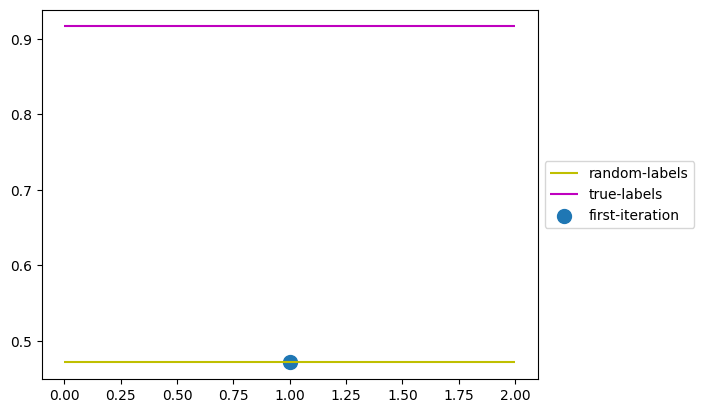

In [30]:
def plot_accuracies(accs=accs):
    colors = list("rgbcmy")
    items_num = len(accs)
    cont = 1

    for x, y in accs.items():
        if x in ['true-labels', 'random-labels', 'true-labels-best-clf']:
            plt.hlines(y, 0, (items_num-2)*2, colors=colors.pop())
        else:
            plt.scatter(cont, y, s=100)
            cont+=2
    plt.legend(accs.keys(), loc="center left",bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_accuracies()

This first iteration had an accuracy very close to the random labeling, we should strive to do better than this. 

Before moving forward let's define the `label_given_rules` function that performs all of the steps you just saw, these are: 
- Apply the rules to a dataframe of comments
- Cast the resulting labels to a numpy array
- Delete all data points with NO_LABEL as label
- Calculate the accuracy of the model using the automatic labels
- Save the accuracy for plotting
- Print some useful metrics of the process

In [31]:
def label_given_rules(df, rules_function, name, 
                      accs_dict=accs, verbose=True):
    
    # Apply labeling rules to the comments
    labels = [rules_function(label) for label in df.text]
    
    # Convert to a numpy array
    labels = np.asarray(labels)
    
    # Save initial number of data points
    initial_size = labels.shape[0]
    
    # Trim points with NO_LABEL label
    X_train_al = df[labels != -1]
    labels = labels[labels != -1]
    
    # Save number of data points after trimming
    final_size = labels.shape[0]
    
    # Compute accuracy
    acc = calculate_accuracy(X_train_al, labels)
    
    # Print useful information
    if verbose:
        print(f"Proportion of data points kept: {final_size/initial_size*100:.2f}%\n")
        print(f"{name} labeling has an accuracy of {acc*100:.2f}%\n")
        
    # Save accuracy to accuracies dictionary
    accs_dict[name] = acc
    
    return X_train_al, labels, acc

Going forward we should come up with rules that have a better coverage of the training data, thus making pattern discovery an easier task. Also notice how the rules were only able to label as either SPAM or NO_LABEL, we should also create some rules that help the identification of NOT_SPAM comments.

### Second iteration - Coming up with better rules

If you inspect the comments in the dataset you might be able to distinguish certain patterns at a glimpse. For example, not spam comments often make references to either the number of views since these were the most watched videos of 2015 or the song in the video and its contents . As for spam comments other common patterns are to promote gifts or ask to follow some channel or website.

Let's create some new rules that include these patterns:

In [32]:
def labeling_rules_2(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x
    ]
    
    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

This new set of rules looks more promising as it includes more patterns to classify as SPAM as well as some patterns to classify as NOT_SPAM. This should result in more data points with a label different to NO_LABEL.

Let's check if this is the case.

Proportion of data points kept: 40.84%

second-iteration labeling has an accuracy of 73.91%



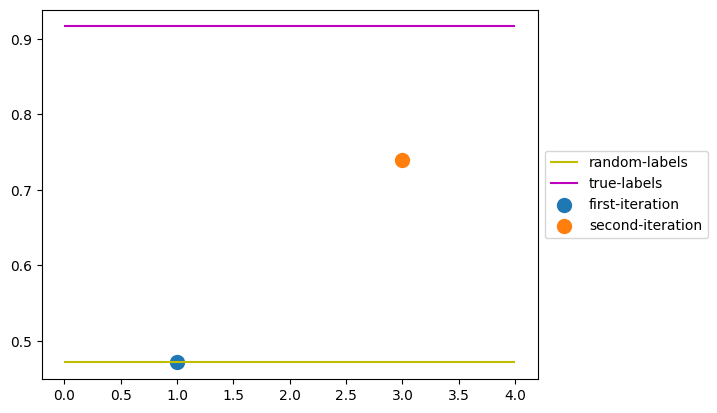

In [33]:
label_given_rules(X_train, labeling_rules_2, "second-iteration")

plot_accuracies()

This time 44% of the original dataset was given a decisive label and there were data points for both labels, this helped the model reach a higher accuracy when compared to the first iteration. Now the accuracy is considerably higher than the random labeling but it is still very far away from the upper bound.

Let's see if we can make it even better!

### Third Iteration - Even more rules

The rules we have defined so far are doing a fair job. Let's add two additional rules, one for classifying SPAM comments and the other for the opposite task.

At a glimpse it looks like NOT_SPAM comments are usually shorter. This may be due to them not including hyperlinks but also in general they tend to be more concrete such as "I love this song!".

Let's take a look at the average number of characters for SPAM comments vs NOT_SPAM oned:

In [34]:
from statistics import mean

print(f"NOT_SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==0].text]):.2f} characters.")
print(f"SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==1].text]):.2f} characters.")

NOT_SPAM comments have an average of 42.35 characters.
SPAM comments have an average of 103.14 characters.


It sure looks like there is a big difference in the number of characters for both types of comments.

To decide on a threshold to classify as NOT_SPAM let's plot a histogram of the number of characters for NOT_SPAM comments:

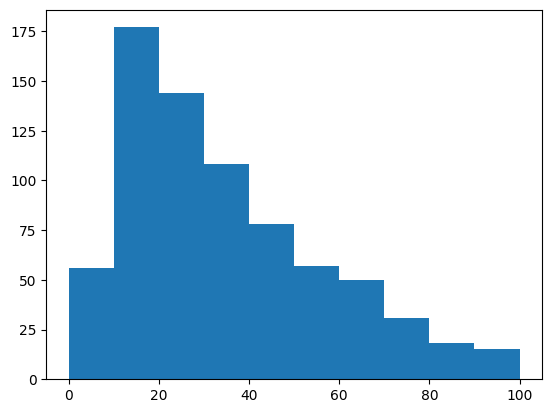

In [35]:
plt.hist([len(t) for t in df_labeled[df_labeled.label==0].text], range=(0,100))
plt.show()

The majority of NOT_SPAM comments have 30 or less characters so we'll use that as a threshold.

Another prevalent pattern in spam comments is to ask users to "check out" a channel, website or link.

Let's add these two new rules:

In [36]:
def labeling_rules_3(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x,
        len(x) < 30
    ]
    

    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x,
        "check out" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 76.15%

third-iteration labeling has an accuracy of 83.61%



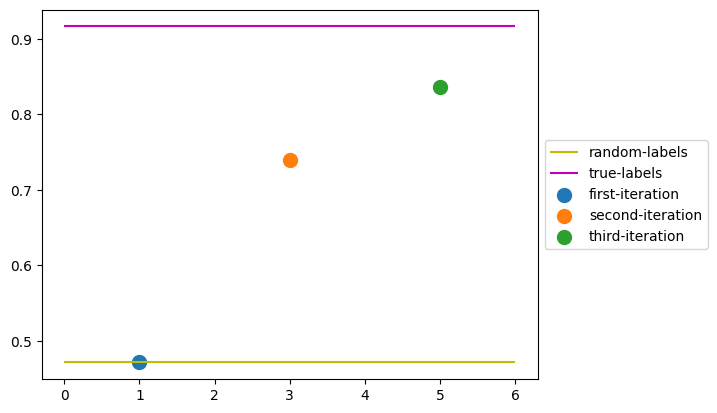

In [37]:
label_given_rules(X_train, labeling_rules_3, "third-iteration")

plot_accuracies()

These new rules do a pretty good job at both, covering the dataset and having a good model accuracy. To be more concrete this labeling strategy reached an accuracy of ~86%! We are getting closer and closer to the upper bound defined by using the true labels.

We could keep going on adding more rules to improve accuracy and we do encourage you to try it out yourself!


### Come up with your own rules

The following cells contain some code to help you inspect the dataset for patterns and to test out these patterns. The ones used before are commented out in case you want start from scratch or re-use them.

In [38]:
# Configure pandas to print out all rows to check the complete dataset
pd.set_option('display.max_rows', None)

# Check NOT_SPAM comments
df_labeled[df_labeled.label==0]

,text,label
1205,fave songï»¿,0
1210,I really am madly in love with this woman!!ï»¿,0
410,Fantastic!!!ï»¿,0
105,PSY - GANGNAM STYLE (ê°•ë‚¨ìŠ¤íƒ€ì¼) M/V: htt...,0
1263,Cool song ï»¿,0
326,In my opinion I think you look better with bla...,0
1230,nice songï»¿,0
976,Eminem and Rihanna sing the song very well.ï»¿,0
1235,I swear Shakira keeps getting more and more go...,0
1290,SHAKIRA SONG WAKA WAKAï»¿,0


In [39]:
# Check SPAM comments
df_labeled[df_labeled.label==1]

,text,label
799,Like this comment if you still jam out to this...,1
1166,Check out my videos guy! :) Hope you guys had ...,1
1269,Subscribe my channel Â I RECORDING FIFA 15 GOA...,1
5,"Hey, check out my new website!! This site is a...",1
389,--&gt;ATTENTION KATYCATS! Katy leads with 7 no...,1
906,Check out this video on YouTube:<br />Looking ...,1
1107,hey its M.E.S here I&#39;m a young up and comi...,1
837,Check out this video on YouTube:ï»¿,1
88,please subscribe i am a new youtuber and need ...,1
15,"Hello! Do you like gaming, art videos, scienti...",1


In [28]:
def your_labeling_rules(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define your rules for classifying as NOT_SPAM
    not_spam_rules = [
#         "view" in x,
#         "song" in x,
#         len(x) < 30
    ]
    

    # Define your rules for classifying as SPAM
    spam_rules = [
#         "free" in x,
#         "subs" in x,
#         "gift" in x,
#         "follow" in x,
#         "http" in x,
#         "check out" in x
    ]
    
    # Classify depending on your rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1


try:
    label_given_rules(X_train, your_labeling_rules, "your-iteration")
    plot_accuracies()
    
except ValueError:
    print("You have not defined any rules.")

You have not defined any rules.


**Congratulations on finishing this ungraded lab!**

By now you should have a better understanding of having good labelled data. In general, **the better your labels are, the better your models will be**. Also it is important to realize that the process of correctly labeling data is a very complex one. **Remember, you can think of each one of the iterations of the automatic labeling process to be a different labeler with different criteria for labeling**. If you assume you are hiring labelers you will want to hire the latter for sure! 

Another important point to keep in mind is that establishing baselines to compare against is really important as they provide perspective on how well your data and models are performing.

**Keep it up!**